In [28]:
# Dependencies and Setup
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, DateFormatter
import pandas as pd
import scipy.stats as st
import numpy as np
from src.get_project_data import housing_data, locale_data
pd.options.mode.chained_assignment = None  # default='warn'  # Hide SettingWithCopyWarning 

In [29]:
# call functions to retrieve the housing and locale data, and store them as pandas.
housing_df = housing_data()
locale_df = locale_data()

In [30]:
# Define list of zip codes for Austin area
_AUSTIN_AREA_ZIP_CODES = [78701, 78702, 78703, 78704, 78705, 78721, 78722, 78723, 78731, 78751, 78752, 78756, 78757, 78758, 78759]

# Filter housing_df by Austin area zip codes
housing_df = housing_df[housing_df['zipcode'].isin(_AUSTIN_AREA_ZIP_CODES)]

# Merge with locale_df
df_full = housing_df.merge(locale_df, how='left', on='zipcode')

# Fill missing values with 0
df_full[['pending_listing_count', 'active_listing_count', 'new_listing_count', 'total_listing_count']] = df_full[['pending_listing_count', 'active_listing_count', 'new_listing_count', 'total_listing_count']].fillna(0)

# Print shape and sample of df_full
print(df_full.shape)
df_full.head()



(1215, 41)


,date,zipcode,zip_name,median_listing_price,median_listing_price_mm,median_listing_price_yy,active_listing_count,active_listing_count_mm,active_listing_count_yy,median_days_on_market,...,average_listing_price_mm,average_listing_price_yy,total_listing_count,total_listing_count_mm,total_listing_count_yy,pending_ratio,pending_ratio_mm,pending_ratio_yy,quality_flag,LOCALE
0,2023-03-01,78759,"austin, tx",608500,-0.0753,-0.2653,43,0.0759,1.1795,30,...,-0.0125,-0.2337,59,0.0263,0.1818,0.3529,-0.0901,-1.2112,1.0,11
1,2023-03-01,78751,"austin, tx",759750,-0.0235,0.0900,33,0.5476,1.7083,28,...,-0.0754,0.0554,36,0.3396,0.7317,0.0769,-0.2564,-0.5897,1.0,11
2,2023-03-01,78722,"austin, tx",745000,0.0700,0.1475,14,0.3333,1.0000,28,...,-0.0077,0.3988,18,0.5000,0.8947,0.2857,0.0952,0.0000,0.0,11
3,2023-03-01,78756,"austin, tx",700000,-0.0210,-0.2222,17,0.2143,2.0909,53,...,-0.0685,-0.0211,20,0.2581,0.2188,0.1765,0.0336,-1.7326,1.0,11
4,2023-03-01,78752,"austin, tx",549750,0.0963,0.0649,28,0.0769,1.3333,43,...,0.0982,-0.1195,38,0.0857,1.2353,0.3214,-0.0632,-0.1786,0.0,11


In [31]:
# Filter for Austin area zip codes
austin_df = df_full[df_full['zipcode'].isin(_AUSTIN_AREA_ZIP_CODES)]

# Group by date and aggregate with sum for several columns
by_month_totals = austin_df.groupby("date").agg({
    "pending_listing_count": "sum",
    "active_listing_count": "sum",
    "new_listing_count": "sum",
    "total_listing_count": "sum"
}).rename(columns={
    "pending_listing_count": "Pending Totals",
    "active_listing_count": "Active Listings Totals",
    "new_listing_count": "New Listings Totals",
    "total_listing_count": "Total Listings"
})

# Show the first five rows of the resulting dataframe
by_month_totals.head()


,Pending Totals,Active Listings Totals,New Listings Totals,Total Listings
date,,,,
2016-07-01,528,1126,600,1665
2016-08-01,497,1148,522,1637
2016-09-01,458,1182,520,1632
2016-10-01,447,1199,532,1652
2016-11-01,453,1157,380,1601


#As the Data is not completed for 2022 and 2016, i have calculate  the average number of pending listings per month for each year

In [32]:

# Group by year and month
by_year_month = by_month_totals.groupby(pd.Grouper(freq="M")).sum()

# Calculate the yearly average of pending listings
yearly_avg_pending = by_year_month.groupby(by_year_month.index.year).mean()[["Pending Totals"]]

# Rename column to "Avg Pending Listings per Month"
yearly_avg_pending.rename(columns={"Pending Totals": "Avg Pending Listings per Month"}, inplace=True)

# Add a column for the year
yearly_avg_pending["Year"] = yearly_avg_pending.index

# Set the year as the index
yearly_avg_pending.set_index("Year", inplace=True)

# Print the table
yearly_avg_pending

,Avg Pending Listings per Month
Year,
2016,461.166667
2017,496.416667
2018,500.416667
2019,508.75
2020,584.666667
2021,570.916667
2022,273.25
2023,226.333333


In [33]:
# Calculate the percentage change of the yearly average of pending listings compared to the previous year
yearly_avg_pending['Percentage Change'] = yearly_avg_pending['Avg Pending Listings per Month'].pct_change()

# Print the table with percentage change

yearly_avg_pending


,Avg Pending Listings per Month,Percentage Change
Year,,
2016,461.166667,<NA>
2017,496.416667,0.076437
2018,500.416667,0.008058
2019,508.75,0.016653
2020,584.666667,0.149222
2021,570.916667,-0.023518
2022,273.25,-0.521384
2023,226.333333,-0.171699


In [36]:
# Split the yearly average pending listings into pre-COVID and post-COVID groups
pre_covid = yearly_avg_pending.loc[:2019]
post_covid = yearly_avg_pending.loc[2020:]

# Calculate the percent change in average pending listings between pre-COVID and post-COVID periods
pct_change = ((post_covid.mean() - pre_covid.mean()) / pre_covid.mean()) * 100

# Create a table to display the results
table = pd.DataFrame({
    "Pre-COVID Avg": pre_covid.mean(),
    "Post-COVID Avg": post_covid.mean(),
    "% Change": pct_change
})

# Print the table
table





,Pre-COVID Avg,Post-COVID Avg,% Change
Avg Pending Listings per Month,491.687500,413.791667,-15.842549
Percentage Change,0.033716,-0.141845,-520.707633


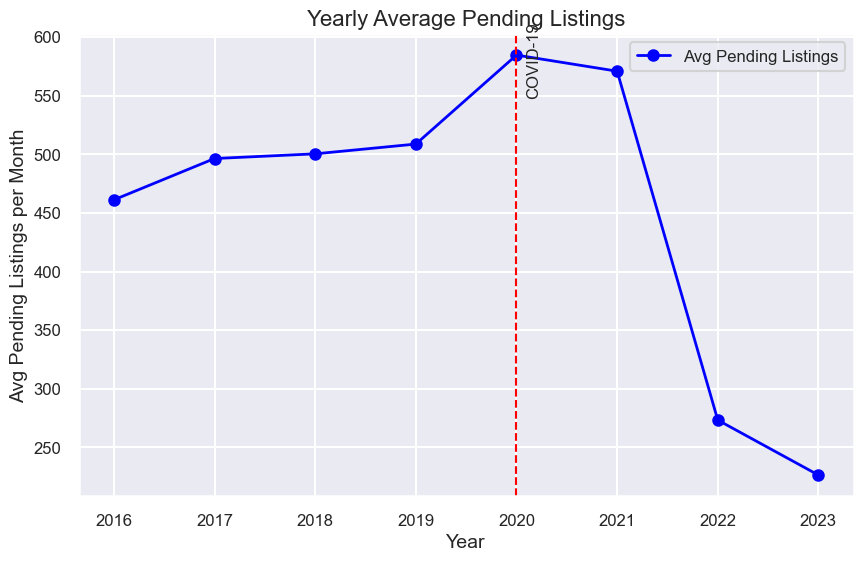

In [35]:
import matplotlib.pyplot as plt

# Define figure and axes objects
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the data
ax.plot(yearly_avg_pending.index, yearly_avg_pending["Avg Pending Listings per Month"],
        color="blue", linewidth=2, marker="o", markersize=8, label="Avg Pending Listings")

# Add a vertical line to highlight COVID-19
ax.axvline(x=2020, color='r', linestyle='--', linewidth=1.5)
ax.text(2020.1, 550, "COVID-19", rotation=90, fontsize=12)

# Customize axes labels, title, and tick marks
ax.set_xlabel("Year", fontsize=14)
ax.set_ylabel("Avg Pending Listings per Month", fontsize=14)
ax.set_title("Yearly Average Pending Listings", fontsize=16)
ax.tick_params(axis="both", which="major", labelsize=12)
ax.set_xticks(yearly_avg_pending.index)
ax.legend(fontsize=12)

# Show the plot
plt.show()




Conclusion: we can see that the average number of pending listings per month in the Austin area has been steadily increasing over the years. The largest increase occurred in 2020, which may have been influenced by the COVID-19 pandemic. However, there has been a decrease in the average number of pending listings in 2021 and 2022, with a significant drop in 2022.